
###Лабораторная работа 7.

Ансамблевые методы: stacking, blending. Оценка out-of-fold.

1. Подобрать подходящую таблицу данных для задачи классификации. Изучить статью А.Г. Дьяконова про стэкинг.

2. Выбрать три различных метода классификации. Применить их к задаче по отдельности. Оценить качество.

3. Реализовать и применить усреднение (blending), в т.ч. взвешенное. Оценить качество.

4. Реализовать и применить стэкинг. Оценить качество.

5. Исследовать влияние смещённости ответов базовых методов на обучающей выборке (если базовые методы и верхнеуровневый метод обучать на одной выборке).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

####1. Подобрать подходящую таблицу данных для задачи классификации:

In [ ]:
# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
data.dropna(inplace=True)
data['income'] = data['income'].map({'<=50K':0, '>50K':1})


# Основная информация о датасете
print("="*50)
print(f"Dataset Size: {len(data):,} rows | {len(data.columns)} columns")
print(f"Target Variable Distribution:\n{data['income'].value_counts().to_string()}")
print("="*50)

# Анализ признаков
feature_info = pd.DataFrame({
    'Data Type': data.dtypes,
    'Unique Values': data.nunique(),
    'Sample Values': [data[col].unique()[:3] for col in data.columns]
}).rename_axis('Feature').reset_index()

print("\n Feature Properties:")
display(feature_info.style
        .format({'Sample Values': lambda x: str(x)[:50]+'...'})
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

# Отображение первых 50 записей
print("\n First 50 Records:")
pd.set_option('display.max_columns', None)
display(data.head(50)
        .style
        .set_properties(**{'background-color': '#f8f9fa', 'color': '#212529'})
        .set_table_styles([{'selector': 'th', 'props': [('background-color', '#e9ecef')]}])
        .format(precision=0))
pd.reset_option('display.max_columns')
# ========== КОНЕЦ НОВОГО КОДА ==========

# Преобразование признаков
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_features = ['age', 'fnlwgt', 'education-num',
                    'capital-gain', 'capital-loss', 'hours-per-week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# Разделение данных
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Dataset Size: 32,561 rows | 15 columns
Target Variable Distribution:
income
0    24720
1     7841

 Feature Properties:


Feature,Data Type,Unique Values,Sample Values
age,int64,73,[39 50 38]...
workclass,object,9,['State-gov' 'Self-emp-not-inc' 'Private']...
fnlwgt,int64,21648,[ 77516 83311 215646]...
education,object,16,['Bachelors' 'HS-grad' '11th']...
education-num,int64,16,[13 9 7]...
marital-status,object,7,['Never-married' 'Married-civ-spouse' 'Divorced']...
occupation,object,15,['Adm-clerical' 'Exec-managerial' 'Handlers-cleane...
relationship,object,6,['Not-in-family' 'Husband' 'Wife']...
race,object,5,['White' 'Black' 'Asian-Pac-Islander']...
sex,object,2,['Male' 'Female']...



 First 50 Records:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


####2. Выбрать три различных метода классификации. Применить их к задаче по отдельности. Оценить качество:

In [ ]:
# Настройка и оптимизация моделей
models = {
    'LR': Pipeline([('model', LogisticRegression(max_iter=1000))]),
    'RF': RandomForestClassifier(),
    'SVM': Pipeline([('scaler', StandardScaler(with_mean=False)),
                    ('model', SVC(probability=True))])
}

param_grid = {
    'LR': {'model__C': [0.1, 1, 10]},
    'RF': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'SVM': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
}

best_models = {}
for name in models:
    grid = GridSearchCV(models[name], param_grid[name], cv=3,
                       scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    proba = grid.predict_proba(X_test)[:,1]
    print(f"{name} | Test AUC: {roc_auc_score(y_test, proba):.3f}")

LR | Test AUC: 0.910
RF | Test AUC: 0.916
SVM | Test AUC: 0.901


####3. Реализовать и применить усреднение (blending), в т.ч. взвешенное. Оценить качество.

In [ ]:
# 3: Blending

# Подготовка hold-out сета
X_train_base, X_holdout, y_train_base, y_holdout = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Обучение базовых моделей и получение предсказаний
base_holdout_preds = {}
base_test_preds = {}
for name, model in best_models.items():
    model.fit(X_train_base, y_train_base)
    base_holdout_preds[name] = model.predict_proba(X_holdout)[:,1]
    base_test_preds[name] = model.predict_proba(X_test)[:,1]  # Важно: предсказания на тестовом наборе

# Обучение блендера на hold-out
blend_matrix_holdout = np.column_stack(list(base_holdout_preds.values()))
blender = LogisticRegression().fit(blend_matrix_holdout, y_holdout)

# Взвешенное усреднение (веса определяем на hold-out)
weights = np.array([roc_auc_score(y_holdout, pred) for pred in base_holdout_preds.values()])
weights /= weights.sum()

# Применение к тестовым данным
weighted_avg_test = np.average(np.column_stack(list(base_test_preds.values())),
                              axis=1, weights=weights)
simple_blend_test = blender.predict_proba(np.column_stack(list(base_test_preds.values())))[:,1]

# Оценка
print(f"\nSimple Blending AUC: {roc_auc_score(y_test, simple_blend_test):.3f}")
print(f"Weighted Blending AUC: {roc_auc_score(y_test, weighted_avg_test):.3f}")


Simple Blending AUC: 0.915
Weighted Blending AUC: 0.914


####4. Реализовать и применить стэкинг. Оценить качество.

In [ ]:
# 4: Stacking

# Генерация мета-признаков
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features = np.zeros((X_train.shape[0], len(best_models)))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    for model_idx, (name, model) in enumerate(best_models.items()):
        model.fit(X_train[train_idx], y_train.iloc[train_idx])
        meta_features[val_idx, model_idx] = model.predict_proba(X_train[val_idx])[:,1]

# Обучение мета-моделей
meta_models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100)
}

stacking_results = {}
for meta_name, meta_model in meta_models.items():
    meta_model.fit(meta_features, y_train)
    test_meta = np.column_stack([model.predict_proba(X_test)[:,1] for model in best_models.values()])
    stacking_proba = meta_model.predict_proba(test_meta)[:,1]
    stacking_results[meta_name] = {
        'AUC': roc_auc_score(y_test, stacking_proba),
        'Accuracy': accuracy_score(y_test, np.round(stacking_proba))
    }

print("\nStacking Results:")
pd.DataFrame(stacking_results).T


Stacking Results:


,AUC,Accuracy
LogisticRegression,0.914817,0.860126
RandomForest,0.906694,0.854906
GradientBoosting,0.917833,0.861201


####5. Исследовать влияние смещённости ответов базовых методов на обучающей выборке (если базовые методы и верхнеуровневый метод обучать на одной выборке)

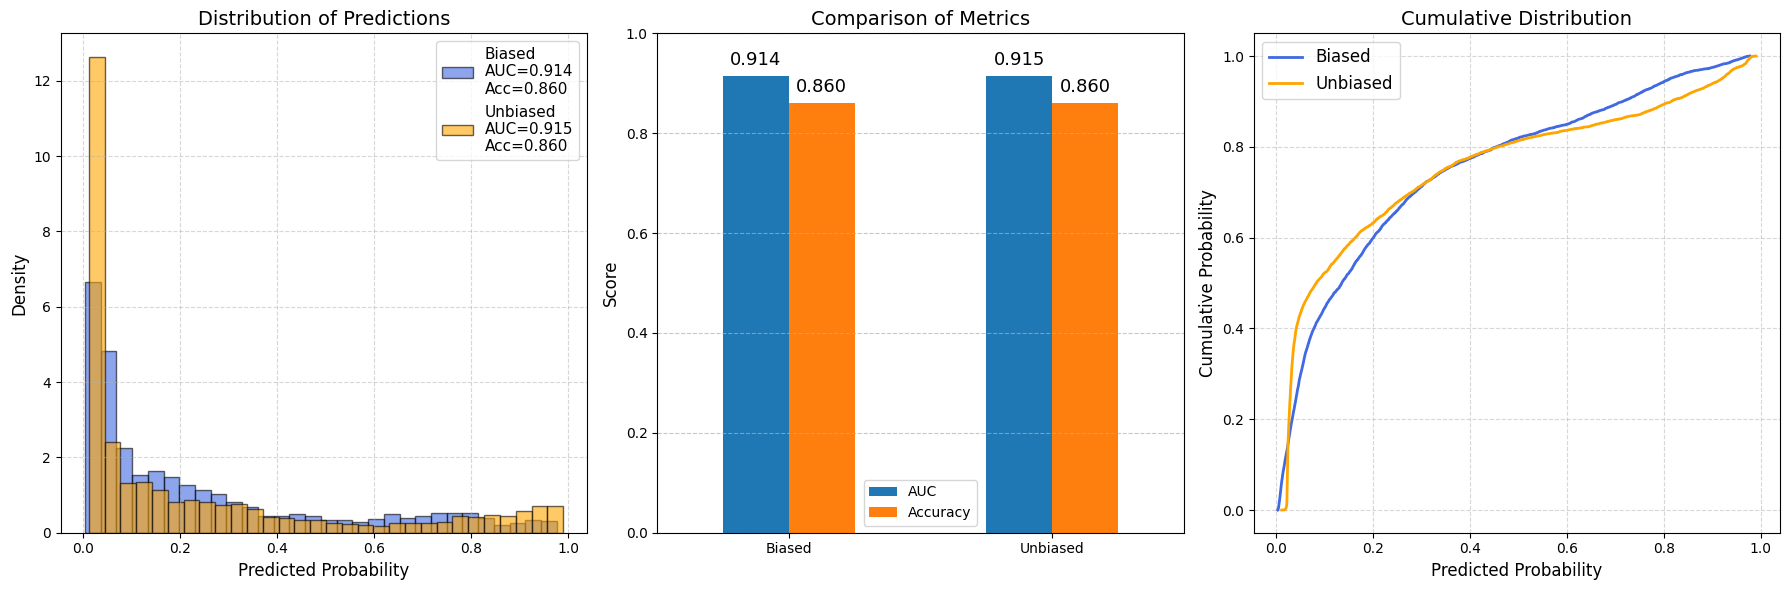

In [ ]:
# # 5: Анализ смещённости

# Calculate metrics
auc_biased = roc_auc_score(y_test, biased_proba)
acc_biased = accuracy_score(y_test, np.round(biased_proba))
auc_unbiased = roc_auc_score(y_test, unbiased_proba)
acc_unbiased = accuracy_score(y_test, np.round(unbiased_proba))

plt.figure(figsize=(18, 6))

# 1. Histogram (density) of predicted probabilities
plt.subplot(1, 3, 1)
plt.hist(biased_proba, bins=30, alpha=0.6, color='royalblue', label=f'Biased\nAUC={auc_biased:.3f}\nAcc={acc_biased:.3f}', density=True, edgecolor='black')
plt.hist(unbiased_proba, bins=30, alpha=0.6, color='orange', label=f'Unbiased\nAUC={auc_unbiased:.3f}\nAcc={acc_unbiased:.3f}', density=True, edgecolor='black')
plt.title('Distribution of Predictions', fontsize=14)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Bar plot of metrics
plt.subplot(1, 3, 2)
metrics_df = pd.DataFrame({
    'Biased': [auc_biased, acc_biased],
    'Unbiased': [auc_unbiased, acc_unbiased]
}, index=['AUC', 'Accuracy'])
ax = metrics_df.T.plot(kind='bar', rot=0, color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
ax.set_title('Comparison of Metrics', fontsize=14)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=13, color='black', xytext=(0, 5), textcoords='offset points')

# 3. Cumulative Distribution Function (CDF)
plt.subplot(1, 3, 3)
biased_sorted = np.sort(biased_proba)
unbiased_sorted = np.sort(unbiased_proba)
cdf_biased = np.arange(1, len(biased_sorted)+1) / len(biased_sorted)
cdf_unbiased = np.arange(1, len(unbiased_sorted)+1) / len(unbiased_sorted)
plt.plot(biased_sorted, cdf_biased, label='Biased', color='royalblue', linewidth=2)
plt.plot(unbiased_sorted, cdf_unbiased, label='Unbiased', color='orange', linewidth=2)
plt.title('Cumulative Distribution', fontsize=14)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
